In [ ]:
# !mkdir genres && wget http://opihi.cs.uvic.ca/sound/genres.tar.gz && tar -xf genres.tar.gz genres/

--2020-06-26 11:25:26--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G   804KB/s    in 25m 27s 

2020-06-26 11:50:53 (784 KB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd drive/MyDrive/

'/content/drive/My Drive'

In [ ]:
pip install torchaudio

     |████████████████████████████████| 1.9MB 4.1MB/s 


In [ ]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

In [ ]:
data_path = '/content/drive/My Drive/genres'

In [ ]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'{data_path}/{g}'):
        songname = f'{data_path}/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 576x576 with 0 Axes>

In [ ]:
img_path = 'img_data'

In [ ]:
batch_size = 8
image_size = 224

In [ ]:
train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [ ]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

In [ ]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [ ]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
#         print(type(image))
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

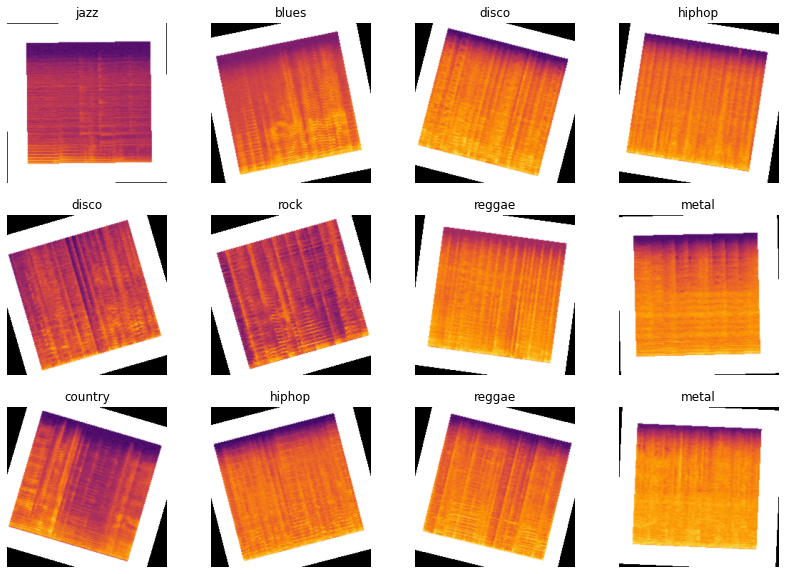

In [ ]:
class_plot(train_data)

In [ ]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 100)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([8, 3, 224, 224])


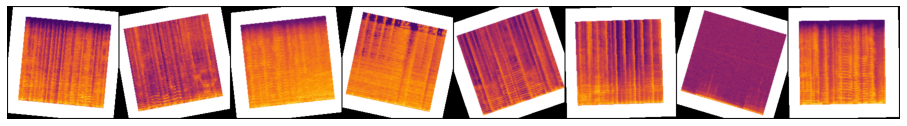

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [ ]:
class Net1(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Hyperparameters
        nb_filters = [64, 128, 128, 128]  # filter sizes
        kernel_size = (3, 3)  # convolution kernel size
        pool_size = [(2, 2), (4, 2), (4, 2), (4, 2), (4, 2)]  # size of pooling area
        GRU_hidden_size = 32  # GRU size
        # Filter sizes
        self.nb_filters = nb_filters
        # Convolution kernel size
        self.kernel_size = kernel_size
        # Size of pooling area
        self.pool_size = pool_size
        # GRU hidden size
        self.GRU_hidden_size = GRU_hidden_size
        # Compute padding
        self.padding = samePaddingOption(kernel_size=kernel_size)

        # Normalization over frequency dimension
        self.norm0 = nn.BatchNorm2d(num_features=100, eps=0.001, momentum=0.01)
        # self.norm0 = nn.BatchNorm2d(num_features=62, eps=0.001, momentum=0.01)
        ### First convolutional layer ###
        self.pad1 = nn.ZeroPad2d(padding=self.padding)
        self.conv1 = nn.Conv2d(in_channels=224, out_channels=nb_filters[0], kernel_size=kernel_size)
        # Activation function
        self.elu1 = nn.ELU()
        # Normalization over channel dimension
        self.norm1 = nn.BatchNorm2d(num_features=nb_filters[0], eps=0.001, momentum=0.01)
        # MaxPool
        self.maxp1 = nn.MaxPool2d(kernel_size=pool_size[0])
        # Dropout
        self.drop1 = nn.Dropout(p=0.1)

        ### Second convolutional layer ###
        self.pad2 = nn.ZeroPad2d(padding=self.padding)
        self.conv2 = nn.Conv2d(in_channels=nb_filters[0], out_channels=nb_filters[1], kernel_size=kernel_size)
        # Activation function
        self.elu2 = nn.ELU()
        # Normalization over channel dimension
        self.norm2 = nn.BatchNorm2d(num_features=nb_filters[1], eps=0.001, momentum=0.01)
        # MaxPool
        self.maxp2 = nn.MaxPool2d(kernel_size=pool_size[1])
        # Dropout
        self.drop2 = nn.Dropout(p=0.1)

        ### Third convolutional layer ###
        self.pad3 = nn.ZeroPad2d(padding=self.padding)
        self.conv3 = nn.Conv2d(in_channels=nb_filters[1], out_channels=nb_filters[2], kernel_size=kernel_size)
        # Activation function
        self.elu3 = nn.ELU()
        # Normalization over channel dimension
        self.norm3 = nn.BatchNorm2d(num_features=nb_filters[2], eps=0.001, momentum=0.01)
        # MaxPool
        self.maxp3 = nn.MaxPool2d(kernel_size=pool_size[2])
        # Dropout
        self.drop3 = nn.Dropout(p=0.1)

        ### Fourth convolutional layer ###
        self.pad4 = nn.ZeroPad2d(padding=self.padding)
        self.conv4 = nn.Conv2d(in_channels=nb_filters[2], out_channels=nb_filters[3], kernel_size=kernel_size)
        # Activation function
        self.elu4 = nn.ELU()
        # Normalization over channel dimension
        self.norm4 = nn.BatchNorm2d(num_features=nb_filters[3], eps=0.001, momentum=0.01)
        # MaxPool
        self.maxp4 = nn.MaxPool2d(kernel_size=pool_size[3])
        # Dropout
        self.drop4 = nn.Dropout(p=0.1)

        ### First and Second recurrent layers (stacked) ###
        self.gru1 = nn.GRU(input_size=nb_filters[3], hidden_size=self.GRU_hidden_size, \
                           batch_first=True)
        self.gru2 = nn.GRU(input_size=self.GRU_hidden_size, hidden_size=self.GRU_hidden_size, \
                           batch_first=True)
        # Dropout
        self.drop5 = nn.Dropout(p=0.3)

        ### Final fully-connected layer ###
        self.fc = nn.Linear(in_features=self.GRU_hidden_size, out_features=nb_classes)

        
    def forward(self, xb, test=False):
        """
        Function describing data path through the network
        :param x: input data
        :param test: boolean value to determine if the forward pass is happening 
                     in testing or not. Since the former takes place in CPU 
                     and the latter in GPU, it flags where to save h0 (in GRU)
        :return: output data
        """

        # starting as (N, H, W, C) -> norm along H -> (N, C, H, W)
        out = self.norm0(x)
        out = out.permute((0, 3, 1, 2))

        # First convolutional layer
        out = self.pad1(out)
        out = self.conv1(out)
        out = self.elu1(out)
        out = self.norm1(out)
        out = self.maxp1(out)
        out = self.drop1(out)

        # Second convolutional layer
        out = self.pad2(out)
        out = self.conv2(out)
        out = self.elu2(out)
        out = self.norm2(out)
        out = self.maxp2(out)
        out = self.drop2(out)

        # Third convolutional layer
        out = self.pad3(out)
        out = self.conv3(out)
        out = self.elu3(out)
        out = self.norm3(out)
        out = self.maxp3(out)
        out = self.drop3(out)

        # Fourth convolutional layer
        out = self.pad4(out)
        out = self.conv4(out)
        out = self.elu4(out)
        out = self.norm4(out)
        out = self.maxp4(out)
        out = self.drop4(out)

        # Before giving the data to the GRU, a reshaping is needed
        # (N, C, H, W) -> (N, W, C)
        out = out.squeeze(2).permute((0, 2, 1))

        # First and Second recurrent layers
        h0 = torch.zeros(1, out.shape[0], self.GRU_hidden_size)
        if torch.cuda.is_available() and (not test):
          h0 = h0.cuda()
        out, _ = self.gru1(out, h0)
        _, out = self.gru2(out, h0)
        # Now out is in the form (1, batch, self.GRU_hidden_size)
        out = out[0]

        out = self.drop5(out)
        # Final fully-connected layer
        out = self.fc(out)
        #out = self.smax(out)

        return out





In [ ]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [ ]:
Net()

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
model = to_device(Net(), device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history = [evaluate(model, val_dl)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
model.freeze()

In [ ]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], val_loss: 2.1834, val_score: 0.2768



Epoch [1], val_loss: 2.1781, val_score: 0.3036



Epoch [2], val_loss: 1.6222, val_score: 0.4643



Epoch [3], val_loss: 1.4575, val_score: 0.4821



Epoch [4], val_loss: 1.2957, val_score: 0.5446
CPU times: user 57.6 s, sys: 15.6 s, total: 1min 13s
Wall time: 1min 56s


In [ ]:
%%time
history += fit_one_cycle(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], val_loss: 1.5828, val_score: 0.4107



Epoch [1], val_loss: 1.2644, val_score: 0.5625



Epoch [2], val_loss: 1.2082, val_score: 0.5714



Epoch [3], val_loss: 1.1267, val_score: 0.6161



Epoch [4], val_loss: 1.2940, val_score: 0.5625



Epoch [5], val_loss: 1.1019, val_score: 0.6250



Epoch [6], val_loss: 1.1285, val_score: 0.5804



Epoch [7], val_loss: 1.1698, val_score: 0.6250



Epoch [8], val_loss: 1.0647, val_score: 0.6250



Epoch [9], val_loss: 1.2509, val_score: 0.6339



Epoch [10], val_loss: 1.2150, val_score: 0.5536



Epoch [11], val_loss: 1.1966, val_score: 0.6518



Epoch [12], val_loss: 1.3830, val_score: 0.5536



Epoch [13], val_loss: 1.4623, val_score: 0.4732



Epoch [14], val_loss: 1.2323, val_score: 0.6161



Epoch [15], val_loss: 1.0781, val_score: 0.6161



Epoch [16], val_loss: 1.1859, val_score: 0.5893



Epoch [17], val_loss: 1.2093, val_score: 0.5982



Epoch [18], val_loss: 1.4194, val_score: 0.5268



Epoch [19], val_loss: 1.2317, val_score: 0.6250



Epoch [20], val_loss: 1.2900, val_score: 0.6429



Epoch [21], val_loss: 1.3027, val_score: 0.5625



Epoch [22], val_loss: 1.2475, val_score: 0.5446



Epoch [23], val_loss: 1.3298, val_score: 0.5714



Epoch [24], val_loss: 1.1906, val_score: 0.6250



Epoch [25], val_loss: 1.7528, val_score: 0.5268



Epoch [26], val_loss: 1.2793, val_score: 0.5714



Epoch [27], val_loss: 1.3719, val_score: 0.5625



Epoch [28], val_loss: 1.2035, val_score: 0.6696



Epoch [29], val_loss: 0.8971, val_score: 0.7232



Epoch [30], val_loss: 1.1261, val_score: 0.6875



Epoch [31], val_loss: 1.0917, val_score: 0.6250



Epoch [32], val_loss: 1.4580, val_score: 0.5893



Epoch [33], val_loss: 1.2797, val_score: 0.6161



Epoch [34], val_loss: 1.2912, val_score: 0.5893



Epoch [35], val_loss: 1.3487, val_score: 0.6339



Epoch [36], val_loss: 1.2123, val_score: 0.5804



Epoch [37], val_loss: 1.3118, val_score: 0.6607



Epoch [38], val_loss: 1.3525, val_score: 0.6518



Epoch [39], val_loss: 1.3774, val_score: 0.6429



Epoch [40], val_loss: 1.2935, val_score: 0.5982



Epoch [41], val_loss: 1.1100, val_score: 0.7143



Epoch [42], val_loss: 1.1844, val_score: 0.6696



Epoch [43], val_loss: 1.5484, val_score: 0.6161



Epoch [44], val_loss: 1.4477, val_score: 0.6250



Epoch [45], val_loss: 1.2676, val_score: 0.6071



Epoch [46], val_loss: 1.5044, val_score: 0.5893



Epoch [47], val_loss: 0.8949, val_score: 0.7411



Epoch [48], val_loss: 1.2866, val_score: 0.6964



Epoch [49], val_loss: 1.2984, val_score: 0.6696



Epoch [50], val_loss: 1.5284, val_score: 0.6161



Epoch [51], val_loss: 1.3518, val_score: 0.6161



Epoch [52], val_loss: 1.5028, val_score: 0.6429



Epoch [53], val_loss: 1.4993, val_score: 0.6250



Epoch [54], val_loss: 1.5600, val_score: 0.5893



Epoch [55], val_loss: 1.2140, val_score: 0.6786



Epoch [56], val_loss: 1.2624, val_score: 0.6429



Epoch [57], val_loss: 1.1601, val_score: 0.6429



Epoch [58], val_loss: 1.0962, val_score: 0.6696



Epoch [59], val_loss: 1.4066, val_score: 0.6339



Epoch [60], val_loss: 1.1009, val_score: 0.7054



Epoch [61], val_loss: 1.4013, val_score: 0.7143



Epoch [62], val_loss: 1.4100, val_score: 0.6696



Epoch [63], val_loss: 1.4033, val_score: 0.6786



Epoch [64], val_loss: 1.3504, val_score: 0.6964



Epoch [65], val_loss: 1.3780, val_score: 0.6964



Epoch [66], val_loss: 1.8266, val_score: 0.6161



Epoch [67], val_loss: 1.6123, val_score: 0.6786



Epoch [68], val_loss: 1.2874, val_score: 0.7232



Epoch [69], val_loss: 1.3041, val_score: 0.7232



Epoch [70], val_loss: 1.1487, val_score: 0.7857



Epoch [71], val_loss: 1.1676, val_score: 0.7321



Epoch [72], val_loss: 1.3318, val_score: 0.6964



Epoch [73], val_loss: 1.5649, val_score: 0.6518



Epoch [74], val_loss: 1.5959, val_score: 0.6875



Epoch [75], val_loss: 1.2109, val_score: 0.7232



Epoch [76], val_loss: 1.2802, val_score: 0.7232



Epoch [77], val_loss: 1.3468, val_score: 0.7054



Epoch [78], val_loss: 1.4886, val_score: 0.7143



Epoch [79], val_loss: 1.1497, val_score: 0.7768



Epoch [80], val_loss: 1.1540, val_score: 0.7321



Epoch [81], val_loss: 1.2844, val_score: 0.7321



Epoch [82], val_loss: 1.4452, val_score: 0.7411



Epoch [83], val_loss: 1.2810, val_score: 0.7321



Epoch [84], val_loss: 1.3606, val_score: 0.7589



Epoch [85], val_loss: 1.2122, val_score: 0.7679



Epoch [86], val_loss: 1.2018, val_score: 0.7500



Epoch [87], val_loss: 1.2755, val_score: 0.7500



Epoch [88], val_loss: 1.3558, val_score: 0.7232



Epoch [89], val_loss: 1.3830, val_score: 0.7411



Epoch [90], val_loss: 1.0638, val_score: 0.7411



Epoch [91], val_loss: 1.1436, val_score: 0.7321



Epoch [92], val_loss: 1.3840, val_score: 0.7232



Epoch [93], val_loss: 1.2596, val_score: 0.7321



Epoch [94], val_loss: 1.1663, val_score: 0.7500



Epoch [95], val_loss: 1.1590, val_score: 0.8036



Epoch [96], val_loss: 1.1974, val_score: 0.7679



Epoch [97], val_loss: 1.3049, val_score: 0.7411



Epoch [98], val_loss: 1.2618, val_score: 0.7143



Epoch [99], val_loss: 1.1888, val_score: 0.7589
CPU times: user 18min 59s, sys: 4min 30s, total: 23min 29s
Wall time: 39min 9s


In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
%%time
history += fit_one_cycle(600, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], val_loss: 1.5271, val_score: 0.5536



Epoch [1], val_loss: 1.3605, val_score: 0.5446



Epoch [2], val_loss: 1.0739, val_score: 0.6071



Epoch [3], val_loss: 1.0767, val_score: 0.6786



Epoch [4], val_loss: 0.9494, val_score: 0.6518



Epoch [5], val_loss: 0.9264, val_score: 0.7054



Epoch [6], val_loss: 0.8862, val_score: 0.7411



Epoch [7], val_loss: 0.9403, val_score: 0.6875



Epoch [8], val_loss: 0.8688, val_score: 0.7679



Epoch [9], val_loss: 0.8789, val_score: 0.7321



Epoch [10], val_loss: 0.8505, val_score: 0.7321



Epoch [11], val_loss: 0.9542, val_score: 0.7232



Epoch [12], val_loss: 0.9812, val_score: 0.6964



Epoch [13], val_loss: 1.0996, val_score: 0.6875



Epoch [14], val_loss: 0.9997, val_score: 0.7054



Epoch [15], val_loss: 0.8472, val_score: 0.7500



Epoch [16], val_loss: 1.1132, val_score: 0.6607



Epoch [17], val_loss: 0.9602, val_score: 0.6875



Epoch [18], val_loss: 1.0218, val_score: 0.6964



Epoch [19], val_loss: 1.1965, val_score: 0.6607



Epoch [20], val_loss: 1.0393, val_score: 0.6518



Epoch [21], val_loss: 1.0517, val_score: 0.6964



Epoch [22], val_loss: 1.0636, val_score: 0.7054



Epoch [23], val_loss: 1.0404, val_score: 0.7232



Epoch [24], val_loss: 1.1321, val_score: 0.6696



Epoch [25], val_loss: 1.2508, val_score: 0.6786



Epoch [26], val_loss: 1.1179, val_score: 0.6607



Epoch [27], val_loss: 1.2227, val_score: 0.7321



Epoch [28], val_loss: 1.2947, val_score: 0.6250



Epoch [29], val_loss: 1.1207, val_score: 0.7143



Epoch [30], val_loss: 1.4978, val_score: 0.6161



Epoch [31], val_loss: 1.4072, val_score: 0.6161



Epoch [32], val_loss: 1.2314, val_score: 0.6964



Epoch [33], val_loss: 1.0018, val_score: 0.6875



Epoch [34], val_loss: 1.2297, val_score: 0.6429



Epoch [35], val_loss: 1.6397, val_score: 0.5714



Epoch [36], val_loss: 1.3232, val_score: 0.6607



Epoch [37], val_loss: 1.1456, val_score: 0.6875



Epoch [38], val_loss: 0.9590, val_score: 0.6964



Epoch [39], val_loss: 1.2989, val_score: 0.6339



Epoch [40], val_loss: 1.6111, val_score: 0.6250



Epoch [41], val_loss: 1.1973, val_score: 0.6429



Epoch [42], val_loss: 0.9721, val_score: 0.6875



Epoch [43], val_loss: 1.2316, val_score: 0.6964



Epoch [44], val_loss: 1.1525, val_score: 0.7232



Epoch [45], val_loss: 1.2737, val_score: 0.6964



Epoch [46], val_loss: 1.2504, val_score: 0.6339



Epoch [47], val_loss: 1.5349, val_score: 0.6607



Epoch [48], val_loss: 1.2499, val_score: 0.6607



Epoch [49], val_loss: 1.1012, val_score: 0.7589



Epoch [50], val_loss: 1.2361, val_score: 0.6607



Epoch [51], val_loss: 1.4768, val_score: 0.6161



Epoch [52], val_loss: 1.2945, val_score: 0.6250



Epoch [53], val_loss: 1.2226, val_score: 0.7143



Epoch [54], val_loss: 1.0508, val_score: 0.7679



Epoch [55], val_loss: 1.4879, val_score: 0.6071



Epoch [56], val_loss: 1.3732, val_score: 0.7054



Epoch [57], val_loss: 1.2423, val_score: 0.6786



Epoch [58], val_loss: 1.5094, val_score: 0.6696



Epoch [59], val_loss: 1.2905, val_score: 0.6607



Epoch [60], val_loss: 1.3673, val_score: 0.6607



Epoch [61], val_loss: 1.3494, val_score: 0.6875



Epoch [62], val_loss: 1.3816, val_score: 0.6607



Epoch [63], val_loss: 1.4758, val_score: 0.6161



Epoch [64], val_loss: 1.3487, val_score: 0.6786



Epoch [65], val_loss: 1.4553, val_score: 0.6339



Epoch [66], val_loss: 1.3897, val_score: 0.6429



Epoch [67], val_loss: 1.3320, val_score: 0.6071



Epoch [68], val_loss: 1.3646, val_score: 0.6429



Epoch [69], val_loss: 1.4465, val_score: 0.6607



Epoch [70], val_loss: 1.3371, val_score: 0.6964



Epoch [71], val_loss: 1.6016, val_score: 0.6429



Epoch [72], val_loss: 1.2174, val_score: 0.6964



Epoch [73], val_loss: 1.4953, val_score: 0.6071



Epoch [74], val_loss: 1.2562, val_score: 0.7143



Epoch [75], val_loss: 1.3945, val_score: 0.6607



Epoch [76], val_loss: 1.4643, val_score: 0.5982



Epoch [77], val_loss: 1.5191, val_score: 0.5982



Epoch [78], val_loss: 1.4019, val_score: 0.6161



Epoch [79], val_loss: 1.3695, val_score: 0.6786



Epoch [80], val_loss: 1.7928, val_score: 0.5893



Epoch [81], val_loss: 1.0624, val_score: 0.7232



Epoch [82], val_loss: 1.4958, val_score: 0.6786



Epoch [83], val_loss: 1.6707, val_score: 0.5714


In [ ]:
torch.save(model.state_dict(), '/content/model.pth')
